Cell 1: Import Libraries and Load Data
First, we import the necessary libraries and load your dataset to understand its structure.

In [6]:
import pandas as pd
import numpy as np

# Load the dataset
# Ensure papers.csv is in the same directory as your notebook
data = pd.read_csv('papers.csv')

# View the first few rows to understand the columns
# We expect columns like 'id', 'year', 'title', 'abstract', 'paper_text'
print(data.head())

# Check the shape of the data
print(f"\nTotal papers: {data.shape[0]}")

     id  year                                              title event_type  \
0     1  1987  Self-Organization of Associative Database and ...        NaN   
1    10  1987  A Mean Field Theory of Layer IV of Visual Cort...        NaN   
2   100  1988  Storing Covariance by the Associative Long-Ter...        NaN   
3  1000  1994  Bayesian Query Construction for Neural Network...        NaN   
4  1001  1994  Neural Network Ensembles, Cross Validation, an...        NaN   

                                            pdf_name          abstract  \
0  1-self-organization-of-associative-database-an...  Abstract Missing   
1  10-a-mean-field-theory-of-layer-iv-of-visual-c...  Abstract Missing   
2  100-storing-covariance-by-the-associative-long...  Abstract Missing   
3  1000-bayesian-query-construction-for-neural-ne...  Abstract Missing   
4  1001-neural-network-ensembles-cross-validation...  Abstract Missing   

                                          paper_text  
0  767\n\nSELF-ORGANIZATI

Cell 2: Data Cleaning and Preprocessing
We need to clean the text data by removing punctuation, converting to lowercase, and removing common "stop words" (like "the", "and") that don't add value to keyword extraction.

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# Download NLTK data (only need to run this once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Create a set of stop words
stop_words = set(stopwords.words('english'))

# Add custom stop words common in research papers if necessary
new_words = ["fig", "figure", "image", "sample", "using",
             "show", "result", "large", "also", "one",
             "two", "three", "four", "five", "seven", "eight", "nine"]
stop_words = stop_words.union(new_words)

def pre_process(text):
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", text)

    # Remove special characters and digits
    text = re.sub("(\\d|\\W)+", " ", text)

    # Convert string to list of words
    text_list = text.split()

    # Remove stopwords and short words (length < 3)
    text_list = [word for word in text_list if word not in stop_words and len(word) >= 3]

    # Lemmatize (convert words to their root form)
    lmtzr = WordNetLemmatizer()
    text_list = [lmtzr.lemmatize(word) for word in text_list]

    return ' '.join(text_list)

# Apply the cleaning function to the 'paper_text' column
# Note: If your column is named 'text' or 'abstract', change 'paper_text' below
docs = data['paper_text'].apply(lambda x: pre_process(x))

print("Data preprocessing complete.")
print(docs.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Data preprocessing complete.
0    self organization associative database applica...
1    mean field theory layer visual cortex applicat...
2    storing covariance associative long term poten...
3    bayesian query construction neural network mod...
4    neural network ensemble cross validation activ...
Name: paper_text, dtype: object


Cell 3: Feature Extraction (TF-IDF)
We will use TF-IDF (Term Frequency-Inverse Document Frequency) to evaluate how important a word is to a document in a collection or corpus.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer with a limited vocabulary size to save memory
# max_df=0.85 means ignore words that appear in > 85% of documents (too common)
# max_features=10000 means keep only the top 10k unique words
cv = TfidfVectorizer(max_df=0.85, max_features=10000)

# Fit and transform the processed titles/text
word_count_vector = cv.fit_transform(docs)

print(f"Shape of TF-IDF matrix: {word_count_vector.shape}")

Shape of TF-IDF matrix: (7241, 10000)


Cell 4: Helper Functions for Keyword Extraction
We need a few functions to sort the TF-IDF vectors and extract the top keywords for a specific document.

In [10]:
def sort_coo(coo_matrix):
    """Sorts the coordinate matrix by score in descending order."""
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """Extracts the top n items from a sorted list."""
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    # Create a dictionary of feature names and scores
    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]] = score_vals[idx]

    return results

# Get the feature names (vocabulary)
feature_names = cv.get_feature_names_out()

Cell 5: Extract Keywords for a Specific Paper
Now we can select a random paper from the dataset and see what keywords our model extracts.

In [11]:
# Select a document index to test (e.g., index 10)
doc_idx = 10

# Get the TF-IDF vector for this document
tf_idf_vector = word_count_vector[doc_idx]

# Sort the items in the vector by score
sorted_items = sort_coo(tf_idf_vector.tocoo())

# Extract top 10 keywords
keywords = extract_topn_from_vector(feature_names, sorted_items, topn=10)

# Display results
print("\n===== Paper Title =====")
print(data['title'][doc_idx])

print("\n===== Abstract =====")
print(data['abstract'][doc_idx])

print("\n===== Extracted Keywords =====")
for k in keywords:
    print(k, keywords[k])


===== Paper Title =====
Learning to Play the Game of Chess

===== Abstract =====
Abstract Missing

===== Extracted Keywords =====
chess 0.795
board 0.341
game 0.261
queen 0.127
play 0.127
evaluation 0.106
network 0.092
explanation 0.091
slope 0.077
move 0.075


Cell 6 (Optional): Generate a Word Cloud
If you want to visualize the most common words across all papers.

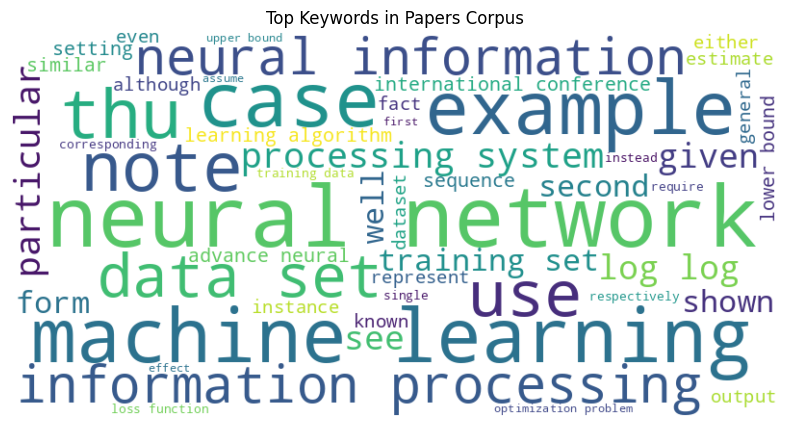

In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Combine all processed text into one big string
text_combined = " ".join(docs)

# Create WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate(text_combined)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Keywords in Papers Corpus")
plt.show()